## Linear Regression with Differential Evolution

In [1]:
import numpy as np
np.random.seed(1)
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

import utilityClasses as uc
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### DE Toy Example

In [2]:
# Given x-y pairs
x_data = [0, 1]
y_data = [0, 1]

# Define the objective function (Mean Squared Error)
def mse_loss(a):
    a0, a1 = a
    y_pred = a0 + a1 * np.array(x_data)
    mse = np.mean((np.array(y_data) - y_pred) ** 2)
    return mse

# Define the bounds for each coefficient (a0 and a1)
bounds = [(-10, 10), (-10, 10)]

# Perform differential evolution optimization
result = differential_evolution(mse_loss, bounds)

# Extract the optimized coefficients a0 and a1
a0_optimized, a1_optimized = result.x

# Print the optimized coefficients and the minimum MSE loss
print("Optimized a0:", a0_optimized)
print("Optimized a1:", a1_optimized)
print("Minimum MSE loss:", result.fun)


Optimized a0: 0.0
Optimized a1: 1.0000000000000009
Minimum MSE loss: 3.944304526105059e-31


In [3]:
def generate_data(n_s, n_i, n_f, n_o):
    # Generate random np array X of shape (n_s, n_i * n_f)
    #X = np.random.rand(n_s, n_i , n_f)
    X = np.random.normal(loc=0.0, scale=1.0, size=(n_s, n_i , n_f))

    # Generate random array Coeff of shape (n_i * n_f)
    #Coeff = np.random.rand(n_i * n_f, n_o)
    Coeff = np.random.normal(loc=0.0, scale=1.0, size=(n_i * n_f, n_o))

    # Reshape Coeff to match the matrix multiplication dimensions
    #Coeff = Coeff.reshape(n_i * n_f, 1)

    # Perform matrix multiplication X * Coeff to get array Y
    Y = np.matmul(X.reshape(-1, X.shape[1]*X.shape[2]), Coeff)
   
    return X, Coeff, Y

# Input values for n_s, n_i, and n_f
n_s = 100
n_i = 24
n_f = 2
n_o = 2

# Perform matrix multiplication
X, Coeff, Y = generate_data(n_s, n_i, n_f, n_o)

(array([[ 1.,  2.,  8., 15., 27., 18., 17.,  5.,  4.,  3.],
        [ 3.,  3.,  9., 19., 15., 18., 20., 10.,  2.,  1.]]),
 array([-20.27421174, -16.31673246, -12.35925318,  -8.4017739 ,
         -4.44429463,  -0.48681535,   3.47066393,   7.42814321,
         11.38562248,  15.34310176,  19.30058104]),
 <a list of 2 BarContainer objects>)

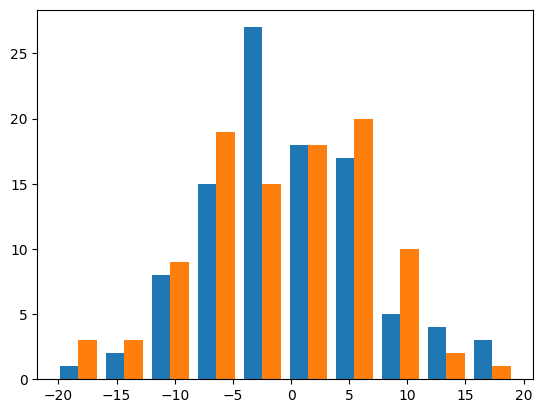

In [4]:
plt.hist(Y)

In [5]:
regularization = 1.e-8
coefficients_init = np.random.normal(0, 1, [1+X.shape[1]*X.shape[2], Y.shape[1]])
bounds_DE = [(np.min(coefficients_init), np.max(coefficients_init))] * coefficients_init.flatten().shape[0]
#bounds_DE = [(-100, 100)] * coefficients_init.flatten().shape[0]

In [6]:
X.shape, Coeff.shape, Y.shape, coefficients_init.shape

((100, 24, 2), (48, 2), (100, 2), (49, 2))

In [7]:
def mean_absolute_percentage_error_MTR(
    y_true, y_pred, *, sample_weight=None, multioutput="uniform_average"
):    
    epsilon = np.finfo(np.float64).eps
    #epsilon = 1e-3
    ape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    mape = np.average(ape, weights=sample_weight)

    return mape

In [8]:
MAPE_Model_GradientBased = uc.LinearModelWithCustomLoss(
    loss_function=mean_absolute_percentage_error_MTR,
    X=X, Y=Y,
    coefficients_init=coefficients_init,
    regularization=regularization,
    bounds=bounds_DE, 
    optimizer='BFGS',
    max_iterations=100, tol=0.001,
    verboose=True
)
MAPE_Model_GradientBased.fit()

counter =  10 , loss 7.116379387051021
counter =  20 , loss 4.954591322249798
counter =  30 , loss 11.020742183711981
counter =  40 , loss 1.4362365512973179
counter =  50 , loss 4.296593619231663
counter =  60 , loss 0.1955304217652933
counter =  70 , loss 0.09139460167430552
counter =  80 , loss 0.04765910925070004
counter =  90 , loss 0.019922956769766024
counter =  100 , loss 0.006680335070296823


In [9]:
MAPE_Model_DE = uc.LinearModelWithCustomLoss(
    loss_function=mean_absolute_percentage_error_MTR,
    X=X, Y=Y,
    coefficients_init=coefficients_init,
    regularization=regularization,
    bounds=bounds_DE, 
    optimizer='DE',
    max_iterations=100, tol=0.001,
    verboose=True
)
MAPE_Model_DE.fit()



counter =  10 , loss 3.1335142797437983
counter =  20 , loss 20.218231228983043
counter =  30 , loss 2.6262307155809568
counter =  40 , loss 2.870331326660114
counter =  50 , loss 1.994723473924985
counter =  60 , loss 4.528343313952406
counter =  70 , loss 15.874787156627571
counter =  80 , loss 7.03555087023873
counter =  90 , loss 4.0244421388965215
counter =  100 , loss 5.353413153968429


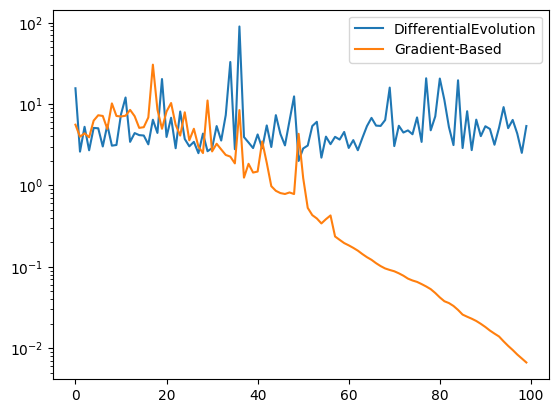

In [10]:
plt.plot(MAPE_Model_DE.loss_values, label='DifferentialEvolution')
plt.plot(MAPE_Model_GradientBased.loss_values, label='Gradient-Based')
plt.yscale('log')
plt.legend()

In [11]:
MAPE_Model_DE_pred = MAPE_Model_DE.predict(X)
MAPE_Model_GradientBased_pred = MAPE_Model_GradientBased.predict(X)

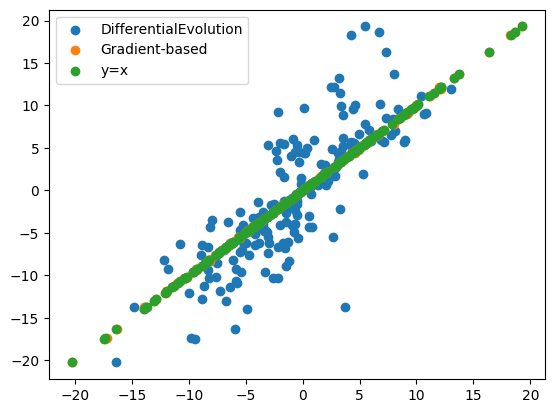

In [12]:
plt.scatter(MAPE_Model_DE_pred.flatten(), Y.flatten(), label='DifferentialEvolution')
plt.scatter(MAPE_Model_GradientBased_pred.flatten(), Y.flatten(), label='Gradient-based')

plt.scatter(Y.flatten(), Y.flatten(), label='y=x')
plt.legend()